In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from tensorflow.keras.regularizers import l1_l2
print("all set to go")

all set to go


In [ ]:
nltk.download('stopwords')

# Load the dataset
file_path = '/content/Textual analysis dataset48000.csv'  # update with your dataset path
data = pd.read_csv(file_path)

# Drop the unnecessary index column if present
if 'Unnamed: 0' in data.columns:
    data = data.drop(['Unnamed: 0'], axis=1)

# Re-use the previous text cleaning function
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)         # Remove mentions
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   # Remove links
    text = re.sub(r'[^a-zA-Z]', ' ', text)                # Remove special characters and numbers
    text = text.lower()                                  # Convert to lowercase
    text = text.split()                                  # Tokenize
    text = [word for word in text if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(text)

# Apply cleaning on the text column
data['clean_text'] = data['text'].apply(clean_text)

# Prepare features and labels
X = data['clean_text'].values
y = data['target'].values

# Tokenization and padding (using the same settings as before)
max_words = 20000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_len)

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def build_cnn_lstm_model():
    model = Sequential()
    model.add(Embedding(max_words, 128, input_length=max_len))
    # Add a 1D Convolutional layer with ReLU activation
    model.add(Conv1D(filters=64, kernel_size=5, activation='tanh'))
    model.add(MaxPooling1D(pool_size=2))
    # Pass the convolved features to a Bidirectional LSTM
    model.add(Bidirectional(LSTM(64,activation='tanh',kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4))))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='tanh',kernel_regularizer=l1_l2(l1=1e-4, l2=1e-4)))
    # Final sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_cnn_lstm_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()
model.get_config()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 128)         │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (64, 96, 64)           │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (64, 48, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (64, 128)              │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,026,181 (30.62 MB)

 Trainable params: 2,675,393 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,350,788 (20.41 MB)

{'name': 'sequential_2',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (64, 100),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'input_dim': 20000,
    'output_dim': 128,
    'embeddings_initializer': {'module': 'keras.initializers',
     'class_name': 'RandomUniform',
     'config': {'seed': None, 'minval': -0.05, 'maxval': 0.05},
     'registered_name': None},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False},

In [ ]:
  with tf.device('/device:GPU:0'):
  early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=64,callbacks=[early_stop, reduce_lr],validation_split=0.2,verbose=1)

Epoch 1/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.6580 - loss: 0.7194 - val_accuracy: 0.7928 - val_loss: 0.4608 - learning_rate: 0.0010
Epoch 2/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8640 - loss: 0.3389 - val_accuracy: 0.7943 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 3/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9412 - loss: 0.1791 - val_accuracy: 0.7773 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 4/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9688 - loss: 0.1109 - val_accuracy: 0.7730 - val_loss: 0.8597 - learning_rate: 0.0010
Epoch 5/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9791 - loss: 0.0808 - val_accuracy: 0.7634 - val_loss: 1.0498 - learning_rate: 0.0010
Epoch 6/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9818 - loss: 0.0683 - val_accuracy: 0.7627 - val_loss: 1.1573 - learning_rate: 0.0010
Epoch 7/25
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9855 - loss:

300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7883 - loss: 0.4639
Validation Accuracy: 79.28%
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4836
           1       0.79      0.79      0.79      4764

    accuracy                           0.79      9600
   macro avg       0.79      0.79      0.79      9600
weighted avg       0.79      0.79      0.79      9600

Confusion Matrix:
[[3839  997]
 [ 992 3772]]
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix:
 [[3839  997]
 [ 992 3772]]


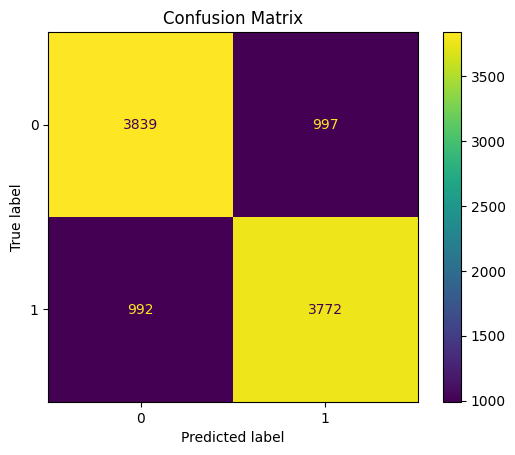

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
auc score 0.8799545972724855


In [ ]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# Generate and print classification report and confusion matrix
y_pred = (model.predict(X_val) > 0.5).astype('int32')
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))



# Single cell: compute & plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # core functions for matrix and display :contentReference[oaicite:0]{index=0}
import matplotlib.pyplot as plt

# 1. Predict probabilities and convert to binary labels (threshold 0.5)
y_pred = (model.predict(X_val).ravel() > 0.5).astype(int)           # assumes binary sigmoid output :contentReference[oaicite:1]{index=1}

# 2. Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)                               # returns raw counts array :contentReference[oaicite:2]{index=2}

# 3. Display and plot
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])  # label classes explicitly :contentReference[oaicite:3]{index=3}
disp.plot(values_format='d')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import  roc_auc_score
y_pred=model.predict(X_val)
print("auc score",roc_auc_score(y_val,y_pred))



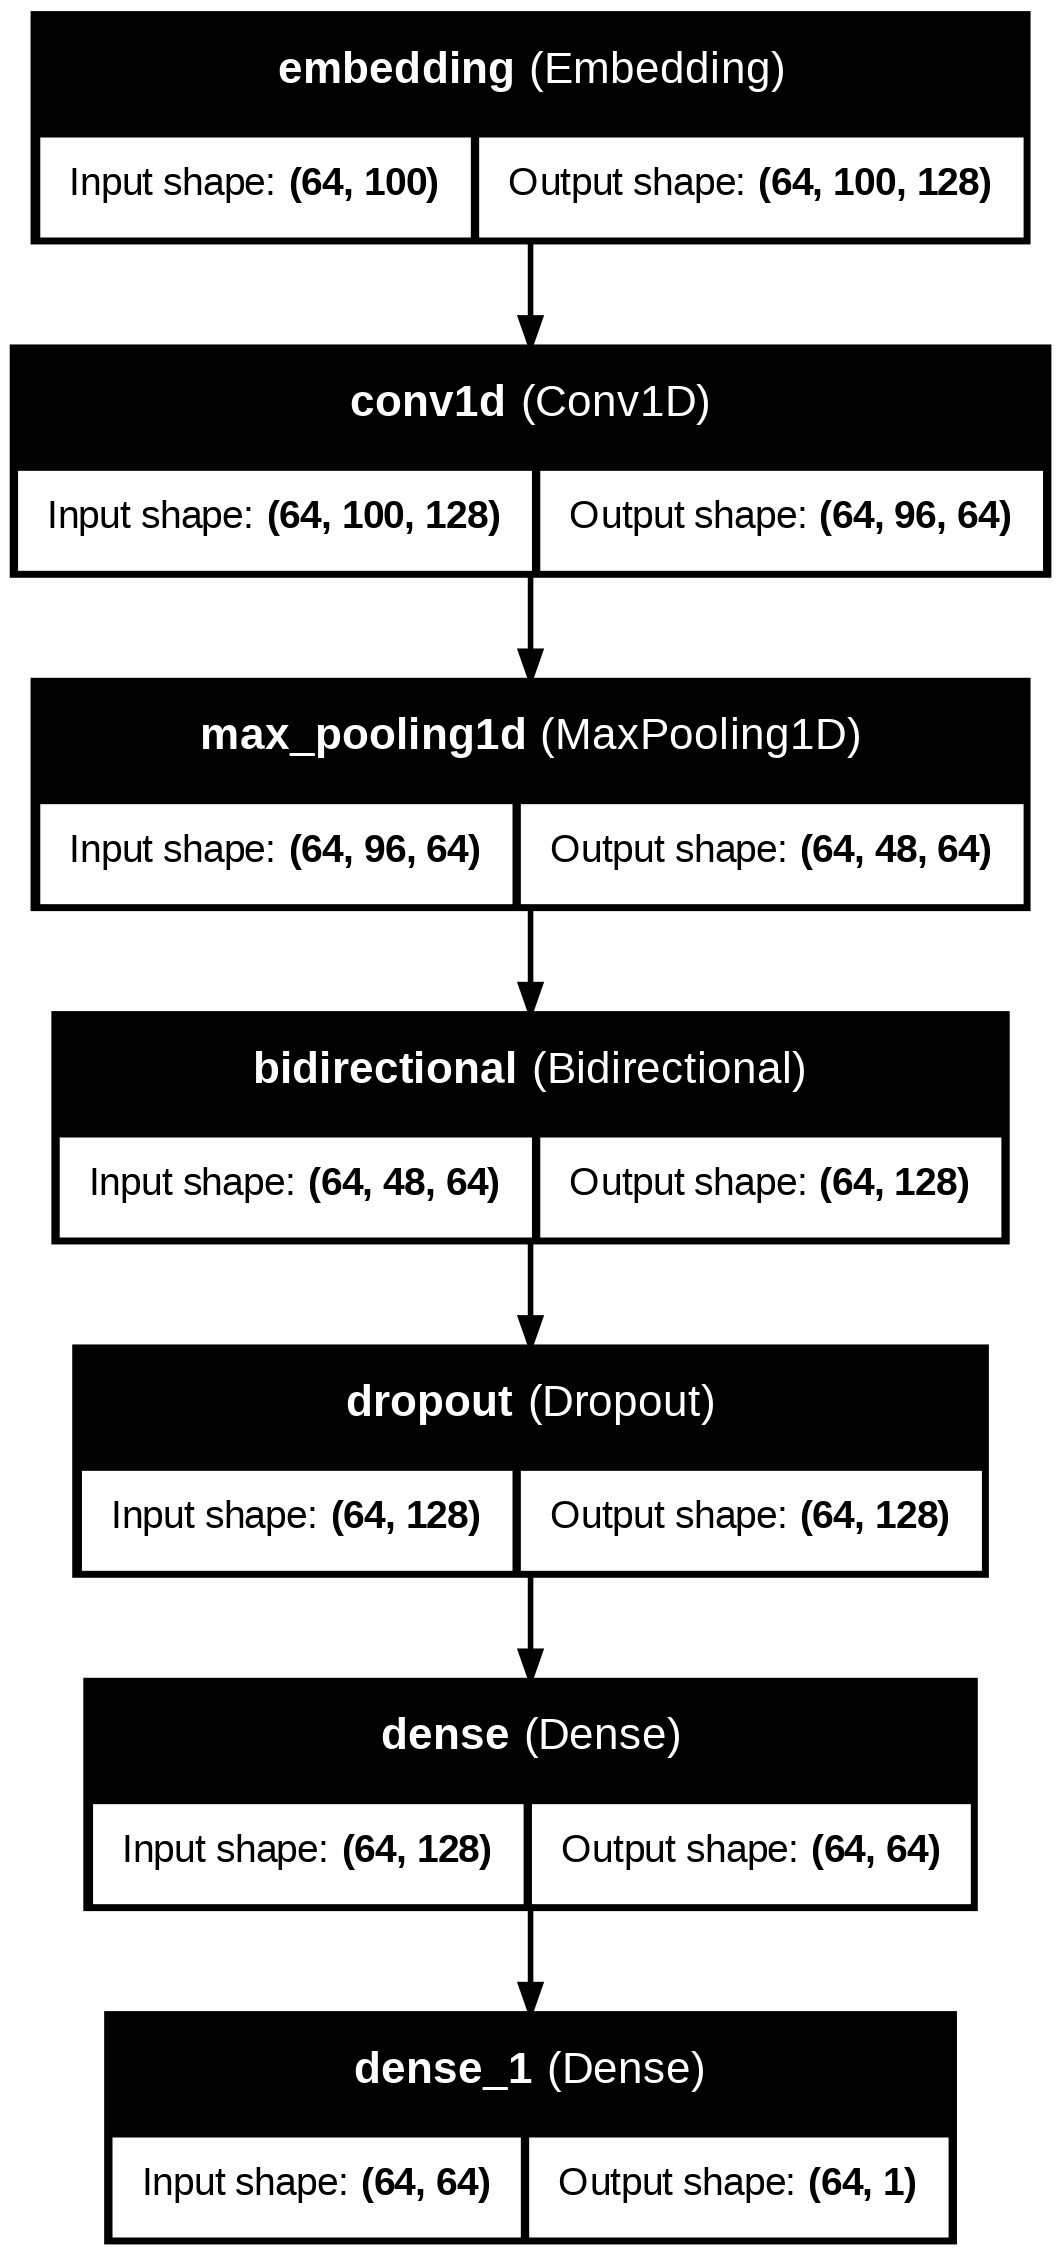

In [ ]:
import keras
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)